In [1]:
import PIL

In [2]:
import numpy as np
import csv
import pandas as pd

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

ModuleNotFoundError: No module named 'fastai'

In [26]:
rows=[]
bbs = []
name = []
with open('training.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        coo = str(row[3]) + ' ' + str(row[1]) + ' ' + str(row[4]) + ' ' + str(row[2])
        if coo[0]!='y':
            bbs.append(coo)
            name.append(row[0])
print (bbs[:4])
print (name[:4])

['143 115 325 495', '61 23 409 457', '13 37 470 601', '162 27 385 602']
['JPEG_20160706_121146_1000145715002.png', 'JPEG_20161119_174038_1000690577600.png', '147444927651111470309333776-Roadster-Men-Casual-Shoes-3041470309333487-1.png', '147772332675720161028_161611.png']


In [33]:
BB_CSV = Path('bb.csv')
df = pd.DataFrame({'fn': name, 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

PermissionError: [Errno 13] Permission denied: 'bb.csv'

In [34]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 'JPEG_20160706_121146_1000145715002.png,143 115 325 495\n',
 'JPEG_20161119_174038_1000690577600.png,61 23 409 457\n',
 '147444927651111470309333776-Roadster-Men-Casual-Shoes-3041470309333487-1.png,13 37 470 601\n',
 '147772332675720161028_161611.png,162 27 385 602\n']

In [39]:
f_model=resnet34
sz=224
bs=64

In [40]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)

In [41]:
PATH = Path('')
JPEGS = 'images/images'

In [42]:
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

In [43]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\siddharth/.torch\models\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 87306240/87306240 [00:17<00:00, 5062476.08it/s]


In [44]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

 66%|████████████████████████████████████████████████████████████████████████▎                                     | 115/175 [36:35<18:24, 18.41s/it, loss=158]

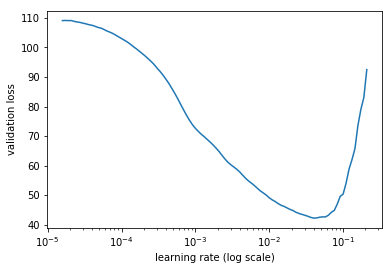

In [45]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [50]:
lr = 9e-3

In [53]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                 
    0      16.750068  10.696481 
    1      13.319157  12.209692                                                                                                                                
    2      8.915288   8.917816                                                                                                                                 


[array([8.91782])]

In [54]:
learn.save('reg4')

In [55]:
learn.load('reg4')

In [102]:
imgpath = 'images/images/JPEG_20161123_184340_1000982358317.png'

In [103]:
trn_tfms, val_tfms = tfms_from_model(f_model, sz)
im = val_tfms(open_image(imgpath)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])

In [110]:
preds=[169,112,337,483]

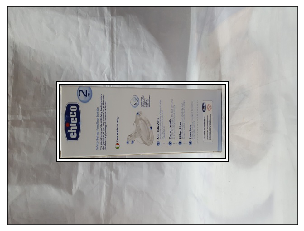

In [112]:
im = open_image(imgpath)
ax = show_img(im)
b = bb_hw(preds)
draw_rect(ax, b)

In [61]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [62]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [66]:
def bb_hw(a): 
    len(a)
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [92]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [113]:
lrs = np.array([lr/100,lr/10,lr])

In [114]:
learn.freeze_to(-2)

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 170/175 [1:32:23<02:32, 30.45s/it, loss=40.1]

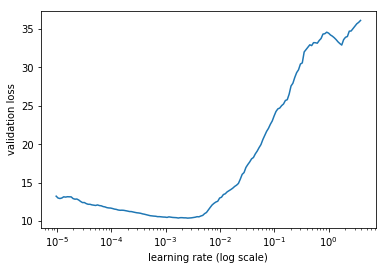

In [115]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [116]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                 
    0      8.760818   5.879719  
    1      8.883914   6.509707                                                                                                                                 
    2      4.84833    4.38116                                                                                                                                  


[array([4.38116])]

In [117]:
learn.save('reg5')

In [121]:
learn.load('reg5')

In [122]:
learn.freeze_to(-3)

In [123]:
learn.fit(lrs, 1, cycle_len=2)

  0%|                                                                                                                                  | 0/175 [00:00<?, ?it/s]

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at C:\Miniconda2\conda-bld\pytorch-cpu_1519449358620\work\torch\lib\TH\THGeneral.c:253

In [ ]:
learn.save('reg6')